# Xarray with Dask Arrays

<img src="images/dataset-diagram-logo.png" 
     align="right"
     width="66%"
     alt="Xarray Dataset">
     
**[Xarray](http://xarray.pydata.org/en/stable/)** is an open source project and Python package that extends the labeled data functionality of [Pandas](https://pandas.pydata.org/) to N-dimensional array-like datasets. It shares a similar API to [NumPy](http://www.numpy.org/) and [Pandas](https://pandas.pydata.org/) and supports both [Dask](https://dask.org/) and [NumPy](http://www.numpy.org/) arrays under the hood.

In [1]:
%matplotlib inline

from dask.distributed import Client
import xarray as xr

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41765,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45245,Total threads: 2
Dashboard: http://127.0.0.1:36169/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:41133,


## Create and register the provenance tracker

In [3]:
from prov_tracking.plugin import ProvTracker

plugin: ProvTracker = ProvTracker(destination = '../../prov_notebook.json', format = 'json', indent = 2, rich_types=True)
client.register_plugin(plugin)
x = plugin.start(client.cluster.scheduler)
x

## Open a sample dataset

We will use some of xarray's tutorial data for this example. By specifying the chunk shape, xarray will automatically create Dask arrays for each data variable in the `Dataset`. In xarray, `Datasets` are dict-like container of labeled arrays, analogous to the `pandas.DataFrame`. Note that we're taking advantage of xarray's dimension labels when specifying chunk shapes.

In [4]:
ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Quickly inspecting the `Dataset` above, we'll note that this `Dataset` has three _dimensions_ akin to axes in NumPy (`lat`, `lon`, and `time`), three _coordinate variables_ akin to `pandas.Index` objects (also named `lat`, `lon`, and `time`), and one data variable (`air`). Xarray also holds Dataset specific metadata as _attributes_.

In [5]:
da = ds['air']
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float64, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Each data variable in xarray is called a `DataArray`. These are the fundamental labeled array objects in xarray. Much like the `Dataset`, `DataArrays` also have _dimensions_ and _coordinates_ that support many of its label-based opperations.

In [6]:
da.data

dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float64, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>

Accessing the underlying array of data is done via the `data` property. Here we can see that we have a Dask array. If this array were to be backed by a NumPy array, this property would point to the actual values in the array.

## Use Standard Xarray Operations

In almost all cases, operations using xarray objects are identical, regardless if the underlying data is stored as a Dask array or a NumPy array.

In [7]:
da2 = da.groupby('time.month').mean('time')
da3 = da - da2
da3

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)> Size: 371MB
dask.array<sub, shape=(2920, 25, 53, 12), dtype=float64, chunksize=(2920, 25, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Call `.compute()` or `.load()` when you want your result as a `xarray.DataArray` with data stored as NumPy arrays. 

<div class="alert alert-info">
    
NOTE: `load()` alters the DataArray inplace whereas `compute()` returns a new DataArray object.

</div>

If you started `Client()` above then you may want to watch the status page during computation.

In [8]:
computed_da = da3.compute()
type(computed_da.data)

numpy.ndarray

In [9]:
computed_da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)> Size: 371MB
array([[[[-5.14975806e+00, -5.47709821e+00, -9.83161290e+00, ...,
          -2.06137097e+01, -1.25446667e+01, -6.77088710e+00],
         [-3.88592742e+00, -3.90562500e+00, -8.17975806e+00, ...,
          -1.87126210e+01, -1.11448750e+01, -5.52096774e+00],
         [-2.71495968e+00, -2.44830357e+00, -6.68943548e+00, ...,
          -1.70037097e+01, -9.99704167e+00, -4.41282258e+00],
         ...,
         [-1.02609677e+01, -9.05825893e+00, -9.39375000e+00, ...,
          -1.53932661e+01, -1.01605833e+01, -6.97169355e+00],
         [-8.58774194e+00, -7.50187500e+00, -7.61467742e+00, ...,
          -1.35697581e+01, -8.43441667e+00, -5.52358871e+00],
         [-7.04653226e+00, -5.84366071e+00, -5.70947581e+00, ...,
          -1.18160887e+01, -6.54195833e+00, -4.02806452e+00]],

        [[-5.05750000e+00, -3.99995536e+00, -9.17193548e+00, ...,
          -2.52225000e+01, -1.53297500e+01, -5.93338710e+00],
         [-4.40729839e+00, -3.25986607e+00, -8.36620968e+00, ...,
          -2.44295565e+01, -1.41292083e+01, -5.66028226e+00],
         [-4.01028226e+00, -2.77741071e+00, -7.87350806e+00, ...,
          -2.40149194e+01, -1.34914583e+01, -5.78564516e+00],
...
          -3.56907258e+00, -2.47420833e+00, -1.16564516e+00],
         [ 6.08588710e-01,  1.47191964e+00,  1.11951613e+00, ...,
          -3.59879032e+00, -2.50400000e+00, -1.15669355e+00],
         [ 6.59838710e-01,  1.48723214e+00,  1.03766129e+00, ...,
          -3.84629032e+00, -2.71833333e+00, -1.33141129e+00]],

        [[ 5.35524194e-01,  4.00892857e-01,  3.08104839e-01, ...,
          -1.68060484e+00, -1.12145833e+00, -1.90927419e-01],
         [ 8.51572581e-01,  8.73303571e-01,  6.26653226e-01, ...,
          -1.33471774e+00, -7.66625000e-01,  1.03225806e-01],
         [ 1.04084677e+00,  1.23178571e+00,  8.63104839e-01, ...,
          -1.06616935e+00, -5.31083333e-01,  3.14475806e-01],
         ...,
         [ 4.71854839e-01,  1.32928571e+00,  1.15487903e+00, ...,
          -3.23411290e+00, -2.23962500e+00, -1.11032258e+00],
         [ 4.14193548e-01,  1.23397321e+00,  1.07866935e+00, ...,
          -3.47326613e+00, -2.56187500e+00, -1.37540323e+00],
         [ 5.32258065e-02,  8.10000000e-01,  6.73266129e-01, ...,
          -4.07241935e+00, -3.12895833e+00, -1.84770161e+00]]]],
      shape=(2920, 25, 53, 12))
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [10]:
da = da.persist()

## Time Series Operations

Because we have a datetime index time-series operations work efficiently. Here we demo the use of xarray's resample method:

In [11]:
resampled_da = da.resample(time='1w').mean('time')
resampled_da.std('time')

/various/shared/università/master-thesis/python/.venv/lib/python3.12/site-packages/xarray/groupers.py:498: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
dask.array<_sqrt, shape=(25, 53), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0

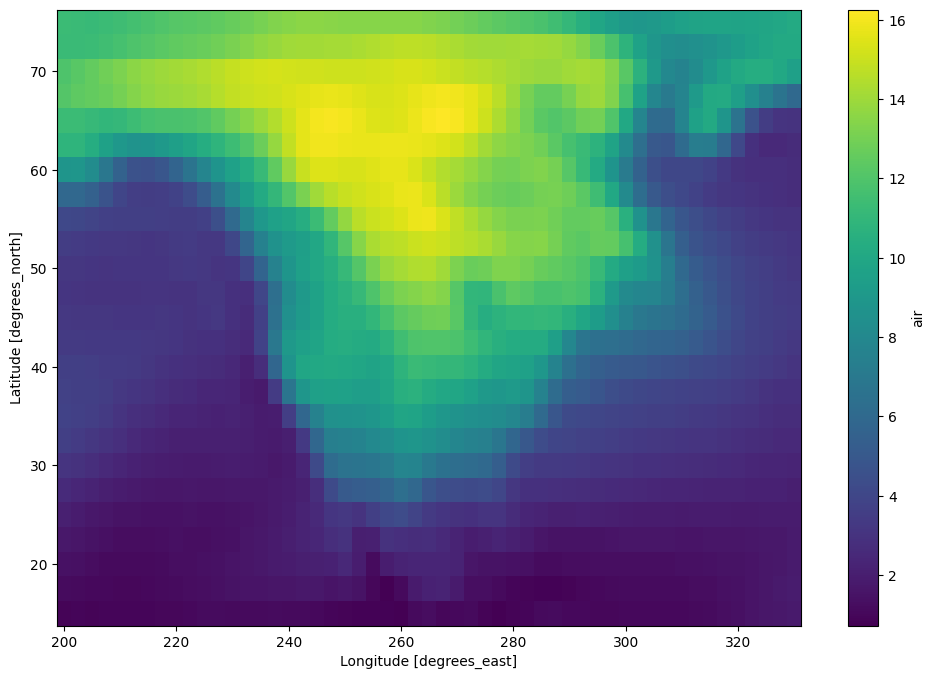

In [12]:
resampled_da.std('time').plot(figsize=(12, 8))

and rolling window operations:

In [13]:
da_smooth = da.rolling(time=30).mean()
da_smooth

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
dask.array<_trim, shape=(2920, 25, 53), dtype=float64, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Since xarray stores each of its coordinate variables in memory, slicing by label is trivial and entirely lazy.

In [14]:
%time da.sel(time='2013-01-01T18:00:00')

CPU times: user 3.27 ms, sys: 35 μs, total: 3.31 ms
Wall time: 3.13 ms


<xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
dask.array<getitem, shape=(25, 53), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
    time     datetime64[ns] 8B 2013-01-01T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [15]:
%time da.sel(time='2013-01-01T18:00:00').load()

CPU times: user 20.3 ms, sys: 3.87 ms, total: 24.2 ms
Wall time: 45.2 ms


<xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
array([[241.89, 241.8 , 241.8 , ..., 234.39, 235.5 , 237.6 ],
       [246.3 , 245.3 , 244.2 , ..., 230.89, 231.5 , 234.5 ],
       [256.6 , 254.7 , 252.1 , ..., 230.7 , 231.8 , 236.1 ],
       ...,
       [296.6 , 296.4 , 296.  , ..., 296.5 , 295.79, 295.29],
       [297.  , 297.5 , 297.1 , ..., 296.79, 296.6 , 296.29],
       [297.5 , 297.7 , 297.5 , ..., 297.79, 298.  , 297.9 ]],
      shape=(25, 53))
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
    time     datetime64[ns] 8B 2013-01-01T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## Custom workflows and automatic parallelization

Almost all of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by xarray, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function, which can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays should be repeatedly applied to xarray objects containing Dask arrays. It works similarly to `dask.array.map_blocks()` and `dask.array.blockwise()`, but without requiring an intermediate layer of abstraction.

Here we show an example using NumPy operations and a fast function from `bottleneck`, which we use to calculate Spearman’s rank-correlation coefficient:

In [16]:
import numpy as np
import xarray as xr
%pip install bottleneck
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

Note: you may need to restart the kernel to use updated packages.


In the examples above, we were working with an some air temperature data. For this example, we'll calculate the spearman correlation using the raw air temperature data with the smoothed version that we also created (`da_smooth`). For this, we'll also have to rechunk the data ahead of time.

In [17]:
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr

<xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
dask.array<transpose, shape=(25, 53), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0

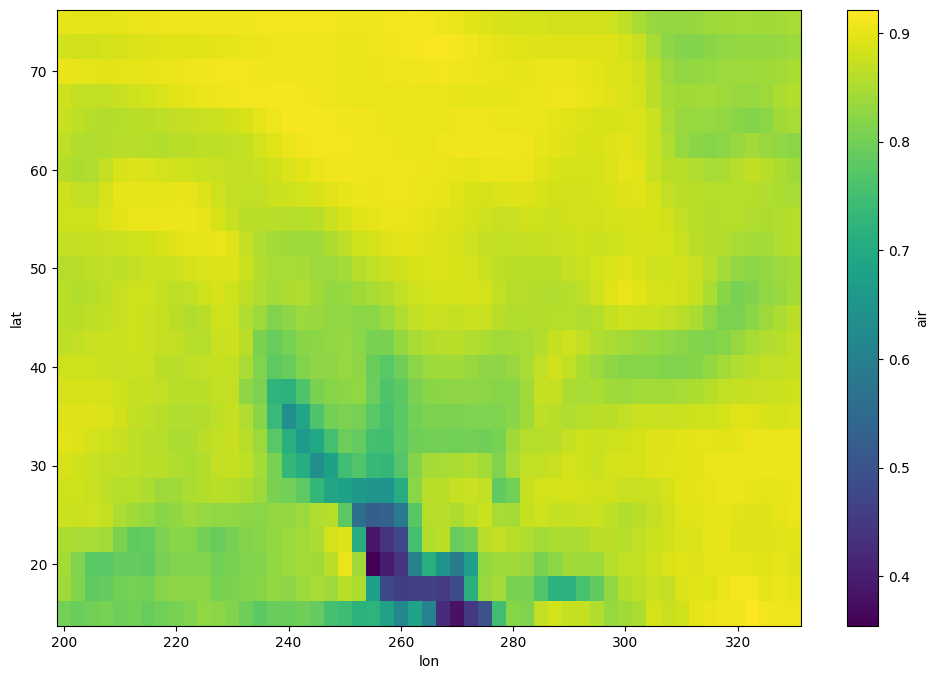

In [18]:
corr.plot(figsize=(12, 8))

In [19]:
client.close()